# Visualizing Results from CSV

In [27]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [28]:
data = pd.read_csv('results.csv')
meta = pd.read_csv('meta.csv')

# Cleaning the data 

In [40]:
df = data.merge(meta,on='model')
df['top_1'] = df['top_1'].str.replace('%','').astype('float64')
df['top_5'] = df['top_5'].str.replace('%','').astype('float64')
df['model_size'] = df['model_size'].str.replace(' Mb','').astype('float64')

In [238]:
df.head()

,project,model,quant,edgetpu,image,first_inference,average,model_size,top_1,top_5
0,image_classification,mobilenet_v1_0.75_224,False,False,cat_720p.jpg,31.651280,21.445810,10.3,68.3,88.1
1,image_classification,mobilenet_v1_0.75_224,False,False,hot_dog.jpg,31.830118,21.297685,10.3,68.3,88.1
2,image_classification,mobilenet_v1_0.75_224,False,False,owl.jpg,31.027201,21.699616,10.3,68.3,88.1
3,image_classification,mobilenet_v1_0.75_224,False,False,face.jpg,31.452305,21.310976,10.3,68.3,88.1
4,image_classification,mobilenet_v1_0.75_224,False,False,cat.bmp,31.556654,21.218704,10.3,68.3,88.1


# Analysis

In [46]:
df.columns

Index(['project', 'model', 'quant', 'edgetpu', 'image', 'first_inference',
       'average', 'model_size', 'top_1', 'top_5'],
      dtype='object')

In [49]:
set(df[''])

{'cat.bmp',
 'cat_1080p.jpg',
 'cat_720p.jpg',
 'face.jpg',
 'hot_dog.jpg',
 'owl.jpg',
 'parrot.jpg'}

In [50]:
df.groupby(['edgetpu','quant']).mean()

first_inference     average  model_size      top_1      top_5
edgetpu quant                                                               
False   False       139.474707  108.488168   32.813636  63.340909  84.063636
        True         52.946507   52.397038    5.714286  61.971429  82.976190
True    True         17.467517    8.986715    5.714286  61.971429  82.976190

# Reduced Inference Time due to Quantization in Mobilenet vs Resnet

In [308]:
mobilenet = []
squeezenet = []
resnet = []
inception = []

i=0
for m in df['model']:
    if 'mobilenet' in m:
        mobilenet.append(i)
    elif 'squeezenet' in m:
        squeezenet.append(i)
    elif 'inception' in m and 'resnet' not in m:
        inception.append(i)
    elif 'resnet' in m:
        resnet.append(i)        
    i += 1

In [279]:
def show_perf_hist(dd, title):

    im = []
    av_tpu_qu = []
    av_qu = []
    av = []
    for i,x in dd.iterrows():
        if x.name[1] and x.name[2]:  
            av_tpu_qu.append(round(x.iloc[0],2))
            im.append(x.name[0])        
        elif x.name[2]:
            av_qu.append(round(x.iloc[0],2))
        else:
            av.append(round(x.iloc[0],2))

    x = np.arange(len(im))  # the label locations
    width = 0.20  # the width of the bars

    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(20)

    rects1 = ax.bar(x - width, av, width, label='CPU')
    rects2 = ax.bar(x, av_qu, width, label='Quantized')
    rects3 = ax.bar(x + width, av_tpu_qu, width, label='TPU + Quantized')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Average Processing Time (ms)',size='large')
#     ax.set_xlabel('Inference Image',size='large')
    ax.set_title(title,size='large')
    ax.set_xticks(x)
    ax.set_xticklabels(im,size='large')
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    
    plt.show()

# MobileNet: Reduced Inference Time due to Edge TPU and Quantization 

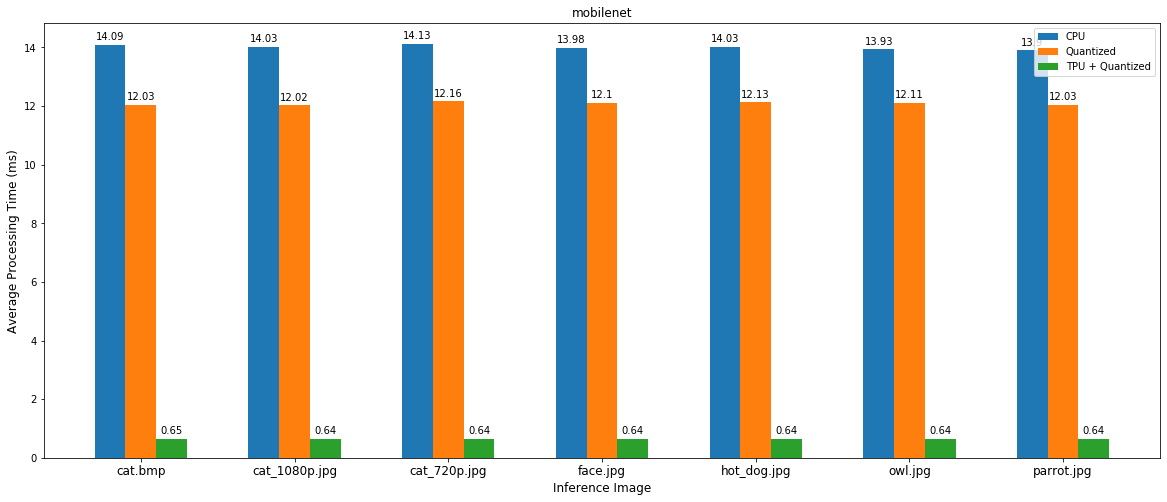

In [237]:
dd = df[['image','edgetpu','quant','average']].iloc[mobilenet].groupby(['image','edgetpu','quant']).mean()
show_perf_hist(dd, 'mobilenet')

# Inception: Reduced Inference Time due to Edge TPU and Quantization 

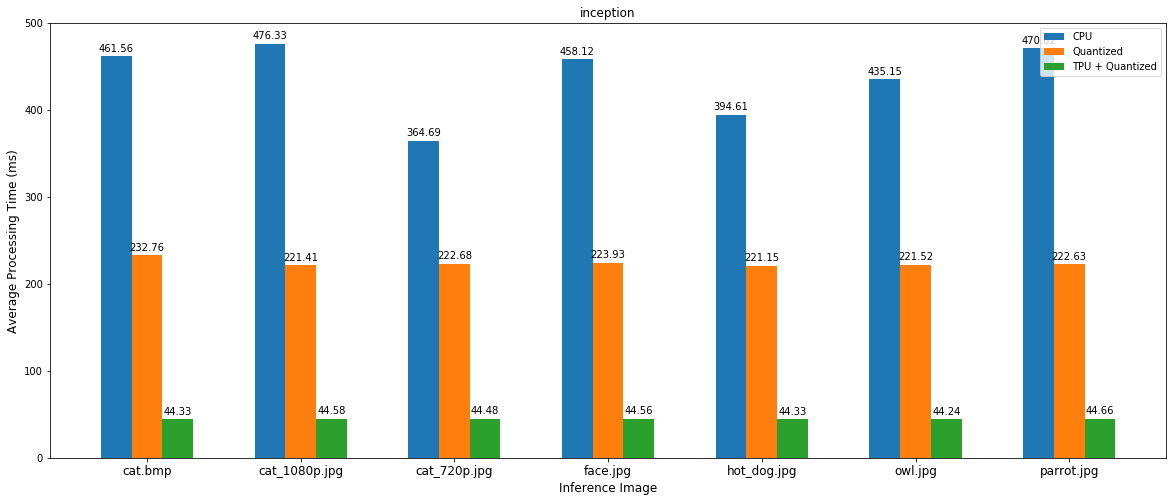

In [239]:
dd = df[['image','edgetpu','quant','average']].iloc[inception].groupby(['image','edgetpu','quant']).mean()
show_perf_hist(dd, 'inception')

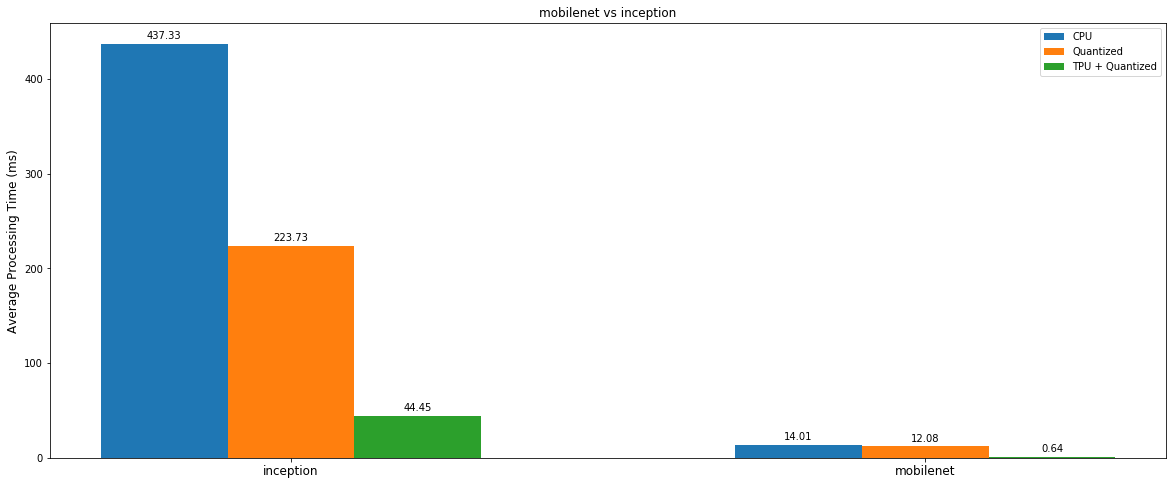

In [280]:
# df.iloc[mobilenet].group
dd1 = df[['edgetpu','quant','average']].iloc[mobilenet]
dd1['model_name'] = 'mobilenet'
dd2 = df[['edgetpu','quant','average']].iloc[inception]
dd2['model_name'] = 'inception'
dd = dd1.append(dd2)
dd = dd.groupby(['model_name','edgetpu','quant']).mean()
show_perf_hist(dd, 'mobilenet vs inception')

# First vs Average Inference Time

In [339]:
df['model_arch'] = ''
for i in range(len(df)):
    x = df.iloc[i]
    if i in mobilenet:
        if x['quant'] and x['edgetpu']:
            df.at[i,'model_arch'] = 'mob_qu_edge'
        elif x['quant'] and not x['edgetpu']:
            df.at[i,'model_arch'] = 'mob_qu'
        else:
            df.at[i,'model_arch'] = 'mob'     
    elif i in inception:
        if x['quant'] and x['edgetpu']:
            df.at[i,'model_arch'] = 'inc_qu_edge'
        elif x['quant'] and not x['edgetpu']:
            df.at[i,'model_arch'] = 'inc_qu'
        else:
            df.at[i,'model_arch'] = 'inc' 
    elif i in squeezenet:
        df.at[i,'model_arch'] = 'squeezenet' 
    elif i in resnet:
        df.at[i,'model_arch'] = 'resnet'

In [322]:
df.at[mobilenet,'model_arch_type'] = 'mobilenet'
df.at[inception,'model_arch_type'] = 'inception'
df.at[squeezenet,'model_arch_type'] = 'squeezenet'
df.at[resnet,'model_arch_type'] = 'resnet'

In [ ]:

df['model'].iloc[mobilenet].unique()
for i in range(len(df)):
    x = df.iloc[i]
    if i in mobilenet:
        if x['quant'] and x['edgetpu']:
            df.at[i,'model_arch'] = 'mob_qu_edge'
        elif x['quant'] and not x['edgetpu']:
            df.at[i,'model_arch'] = 'mob_qu'
        else:
            df.at[i,'model_arch'] = 'mob'     
    elif i in inception:
        if x['quant'] and x['edgetpu']:
            df.at[i,'model_arch'] = 'inc_qu_edge'
        elif x['quant'] and not x['edgetpu']:
            df.at[i,'model_arch'] = 'inc_qu'
        else:
            df.at[i,'model_arch'] = 'inc' 
    elif i in squeezenet:
        df.at[i,'model_arch'] = 'squeezenet' 
    elif i in resnet:
        df.at[i,'model_arch'] = 'resnet'

In [410]:
dd

,average,first_inference
model_arch,,
inc,437.325445,535.267077
inc_qu,223.727204,225.932303
inc_qu_edge,44.454603,61.383410
mob,14.012764,25.865776
mob_qu,12.084057,12.243966
mob_qu_edge,0.641329,7.134365
resnet,618.084259,758.545168
squeezenet,37.703305,41.100858


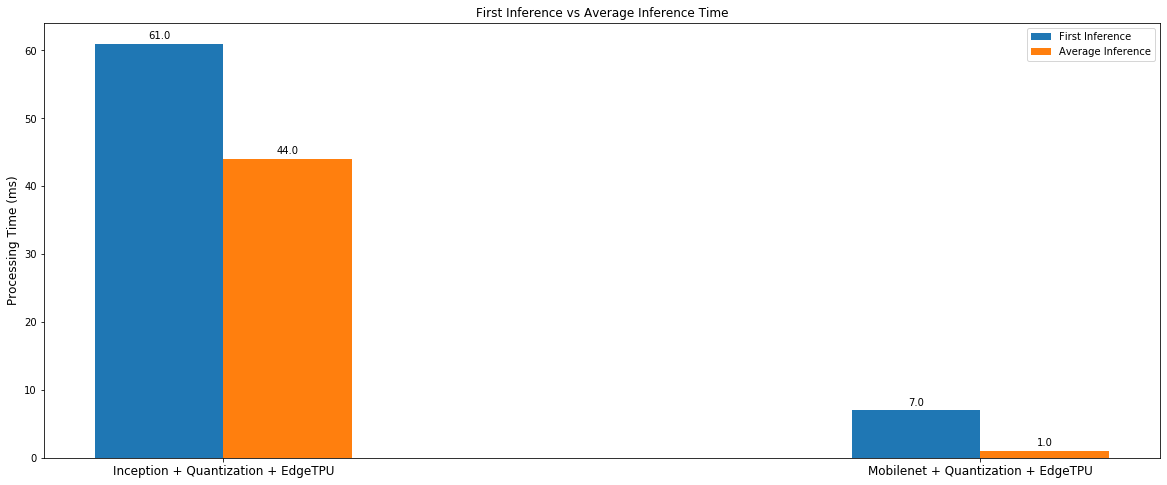

In [412]:
dd = df[['model_arch','average','first_inference']].groupby(['model_arch']).mean()

arch = []
av = []
first = []

for i,x in dd.iterrows():
    if x.name == 'inc_qu_edge':
        arch.append('Inception + Quantization + EdgeTPU')
        av.append(round(x[0]))
        first.append(round(x[1]))
    if x.name == 'mob_qu_edge':
        arch.append('Mobilenet + Quantization + EdgeTPU')
        av.append(round(x[0]))
        first.append(round(x[1]))

x = np.arange(len(arch))  # the label locations
width = 0.17  # the width of the bars

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(20)

rects1 = ax.bar(x - width/2, first, width, label='First Inference')
rects3 = ax.bar(x + width/2, av, width, label='Average Inference')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Processing Time (ms)',size='large')
#     ax.set_xlabel('Inference Image',size='large')
ax.set_title('First Inference vs Average Inference Time',size='large')
ax.set_xticks(x)
ax.set_xticklabels(arch,size='large')
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
# autolabel(rects2)
autolabel(rects3)

plt.show()

In [384]:
dd.iloc[[0,3,6,7]]

,average,model_size
model_arch,,
inc,437.325445,133.000000
mob,14.012764,8.917647
resnet,618.084259,149.650000
squeezenet,37.703305,5.000000


In [444]:
dd = df[['model','average','model_size','model_arch_type']].groupby(['model','model_arch_type']).mean()
dd

,,average,model_size
model,model_arch_type,,
inception_resnet_v2,resnet,521.868590,121.0
inception_v1_quant,inception,32.579457,6.4
inception_v2_quant,inception,53.586898,11.0
inception_v3,inception,251.183763,95.3
inception_v3_quant,inception,150.399514,23.0
inception_v4,inception,623.467126,170.7
inception_v4_quant,inception,299.797746,41.0
mobilenet_v1_0.25_128,mobilenet,2.259471,1.9
mobilenet_v1_0.25_128_quant,mobilenet,1.039771,0.5


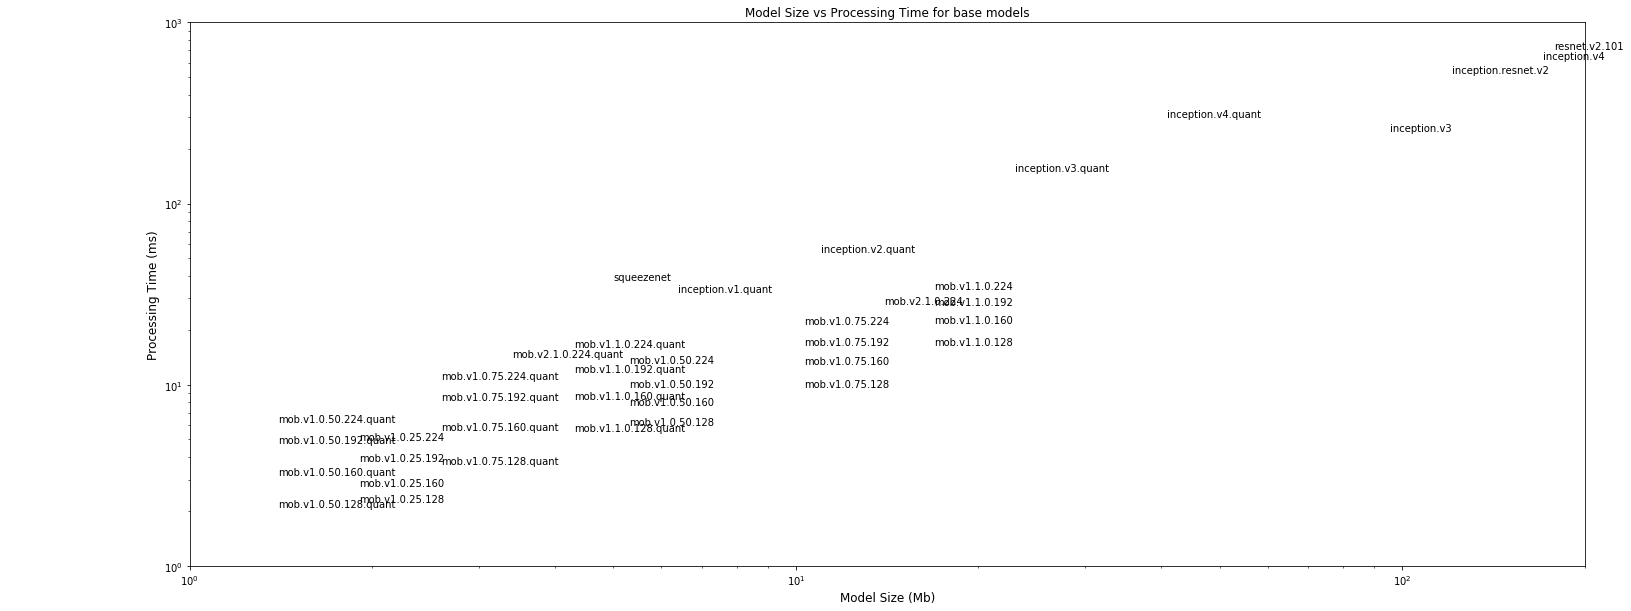

In [482]:
# y = list(dd['average'].iloc[[0,3,6,7]])
# x = list(dd['model_size'].iloc[[0,3,6,7]])
# n = [x[0] for x in dd.iloc[[0,3,6,7]].iterrows()]
y = list(dd['average'])
x = list(dd['model_size'])
n = [z[0] for z in dd.iterrows()]
labs = list([x[0][1] for x in dd.iterrows()])

fig, ax = plt.subplots()

# for color in ['blue', 'orange', 'green']:
#     n = 750
#     x, y = np.random.rand(2, n)
#     scale = 200.0 * np.random.rand(n)
#     ax.scatter(x, y, c=color, s=scale, label=color,
#                alpha=0.3, edgecolors='none')
    
ax.set_ylim([1,1000])
ax.set_xlim([1,200])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('Model Size vs Processing Time for base models',size='large')
ax.set_xlabel('Model Size (Mb)',size='large')
ax.set_ylabel('Processing Time (ms)',size='large')

# ax.scatter(x, y)
# ax.legend(x,labs)
fig.set_figheight(10)
fig.set_figwidth(25)

for i, txt in enumerate(n):
    

    if txt == 'mobilenet':
        ax.scatter(x[i], y[i], color='blue')
    if txt == 'inception':
        ax.scatter(x[i], y[i], color='red') 
    if txt == 'resnet':
        ax.scatter(x[i], y[i], color='green') 
    if txt == 'squeezenet':
        ax.scatter(x[i], y[i], color='black')   
        
#     ax.annotate(txt[0].replace('mobilenet','mob').replace('_','.'), (x[i], y[i]))
        

In [472]:
dd

,,average,model_size
model,model_arch_type,,
inception_resnet_v2,resnet,521.868590,121.0
inception_v1_quant,inception,32.579457,6.4
inception_v2_quant,inception,53.586898,11.0
inception_v3,inception,251.183763,95.3
inception_v3_quant,inception,150.399514,23.0
inception_v4,inception,623.467126,170.7
inception_v4_quant,inception,299.797746,41.0
mobilenet_v1_0.25_128,mobilenet,2.259471,1.9
mobilenet_v1_0.25_128_quant,mobilenet,1.039771,0.5


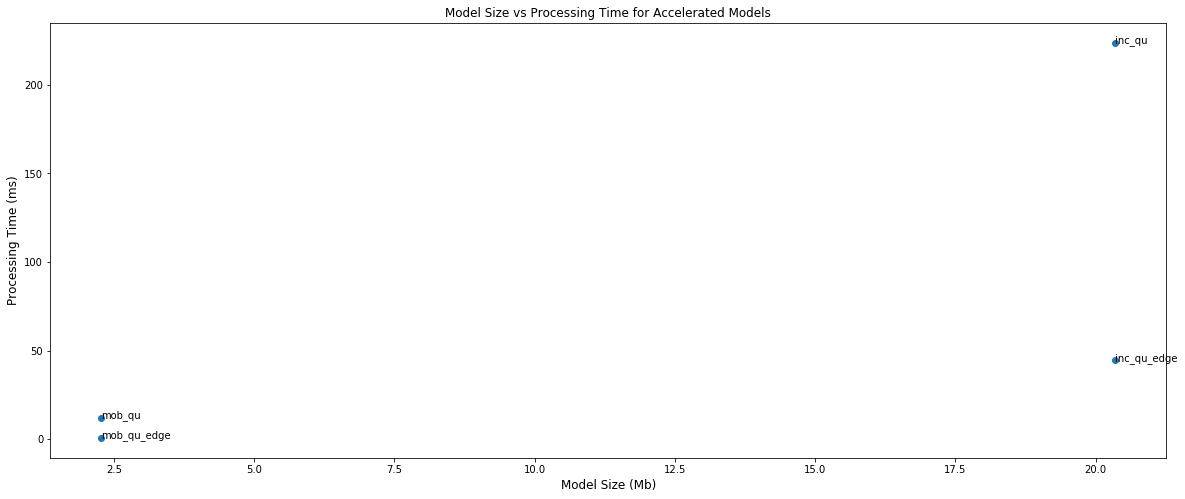

In [408]:
y = list(dd['average'].iloc[[1,2,4,5]])
x = list(dd['model_size'].iloc[[1,2,4,5]])
n = [x[0] for x in dd.iloc[[1,2,4,5]].iterrows()]

fig, ax = plt.subplots()
ax.set_title('Model Size vs Processing Time for Accelerated Models',size='large')
ax.set_xlabel('Model Size (Mb)',size='large')
ax.set_ylabel('Processing Time (ms)',size='large')
fig.set_figheight(8)
fig.set_figwidth(20)
ax.scatter(x, y)


for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

In [499]:
df

,project,model,quant,edgetpu,image,first_inference,average,model_size,top_1,top_5,model_arch,model_arch_type
0,image_classification,mobilenet_v1_0.75_224,False,False,cat_720p.jpg,31.651280,21.445810,10.3,68.3,88.1,mob,mobilenet
1,image_classification,mobilenet_v1_0.75_224,False,False,hot_dog.jpg,31.830118,21.297685,10.3,68.3,88.1,mob,mobilenet
2,image_classification,mobilenet_v1_0.75_224,False,False,owl.jpg,31.027201,21.699616,10.3,68.3,88.1,mob,mobilenet
3,image_classification,mobilenet_v1_0.75_224,False,False,face.jpg,31.452305,21.310976,10.3,68.3,88.1,mob,mobilenet
4,image_classification,mobilenet_v1_0.75_224,False,False,cat.bmp,31.556654,21.218704,10.3,68.3,88.1,mob,mobilenet
...,...,...,...,...,...,...,...,...,...,...,...,...
443,image_classification,mobilenet_v1_0.50_192,False,False,owl.jpg,14.452770,9.755142,5.3,61.7,83.5,mob,mobilenet
444,image_classification,mobilenet_v1_0.50_192,False,False,face.jpg,13.980046,9.792718,5.3,61.7,83.5,mob,mobilenet
445,image_classification,mobilenet_v1_0.50_192,False,False,cat.bmp,14.555380,9.617858,5.3,61.7,83.5,mob,mobilenet
446,image_classification,mobilenet_v1_0.50_192,False,False,parrot.jpg,14.271082,9.496047,5.3,61.7,83.5,mob,mobilenet


In [505]:
df['edgetpu'][0]

False

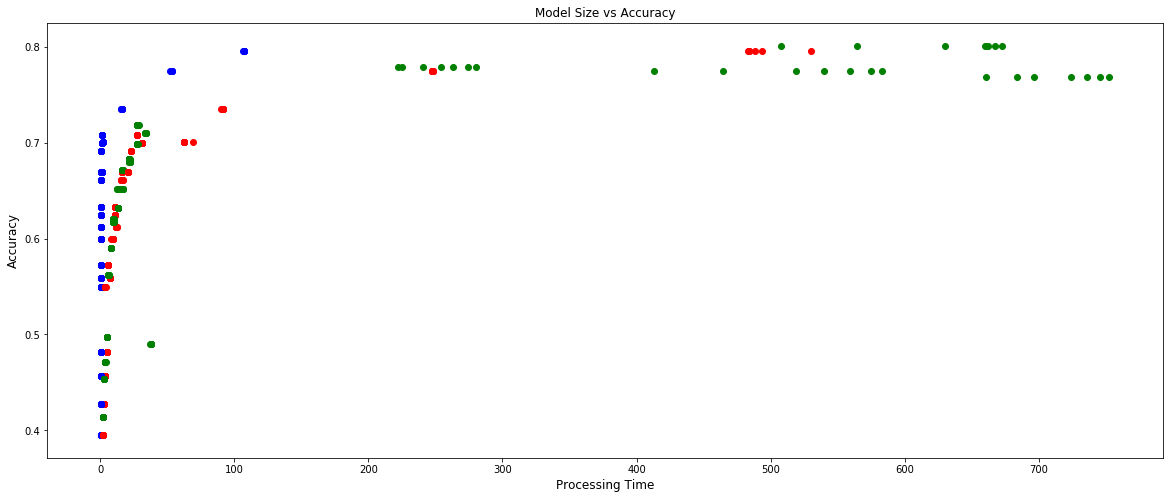

In [514]:
x = list(df['average'])
y = list(df['top_1']/100)
# n = [x[0] for x in dd.iloc[[1,2,4,5]].iterrows()]
n = list(df['model_arch_type'])

fig, ax = plt.subplots()
ax.set_title('Model Size vs Accuracy',size='large')
ax.set_xlabel('Processing Time',size='large')
ax.set_ylabel('Accuracy',size='large')
fig.set_figheight(8)
fig.set_figwidth(20)
# ax.scatter(x, y)

for i, txt in enumerate(n):
#     ax.annotate(txt, (x[i], y[i]))    
    if df['edgetpu'][i]:
        ax.scatter(x[i], y[i], color='blue')
    elif df['quant'][i]:
        ax.scatter(x[i], y[i], color='red')
    else:
        ax.scatter(x[i], y[i], color='green')

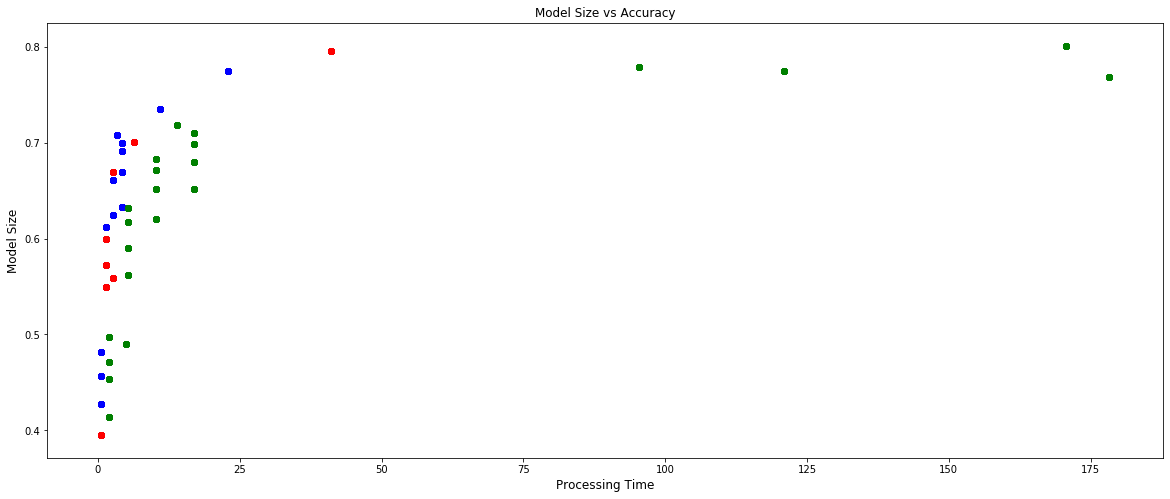

In [516]:
x = list(df['model_size'])
y = list(df['top_1']/100)
# n = [x[0] for x in dd.iloc[[1,2,4,5]].iterrows()]
n = list(df['model_arch_type'])

fig, ax = plt.subplots()
ax.set_title('Model Size vs Accuracy',size='large')
ax.set_xlabel('Processing Time',size='large')
ax.set_ylabel('Model Size',size='large')
fig.set_figheight(8)
fig.set_figwidth(20)
# ax.scatter(x, y)

for i, txt in enumerate(n):
#     ax.annotate(txt, (x[i], y[i]))    
    if df['edgetpu'][i]:
        ax.scatter(x[i], y[i], color='blue')
    elif df['quant'][i]:
        ax.scatter(x[i], y[i], color='red')
    else:
        ax.scatter(x[i], y[i], color='green')

In [488]:
df.to_csv('lol.csv',index=False)